- This is a walkthrough of the code
- This notebook also includes helper functions -- which would better be placed in a separate python file -- for the sake of clarity.
- Here, I have also left additional print statements to illustrate dimensions along the way 
- The actual training was only done for 50 iterations, just to check that the code is functioning. 
- Full training will be done on google colab

- In a separate notebook, create a single function that runs everything in this notebook all at once.

In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model

<h3> 1) Load images and pre-process </h3>

<h5> 1.1) Write function to load and resize images </h5>

In [2]:
def load_resize(file_path, img_size):
    """
    Loads image, resizes, and saves as numpy array. Then converts into Tensor. 

    Arguments
    file_path
    img_size -- integer

    Returns
    Image as Tensor of shape (1, img_size, img_size, 3)
    """
    # Load image, resize, and convert into numpy array
    image = np.array(Image.open(file_path).resize((img_size, img_size)))        # (img_size, img_size, 3)

    # Reshape
    image = np.reshape(image, ((1,) + image.shape))                             # (1, img_size, img_size, 3)

    # Convert to Tensor
    image = tf.constant(image)

    print(image.shape)
    imshow(image[0])
    plt.show()

    return image

<h5> Load content image </h5>

(1, 400, 400, 3)


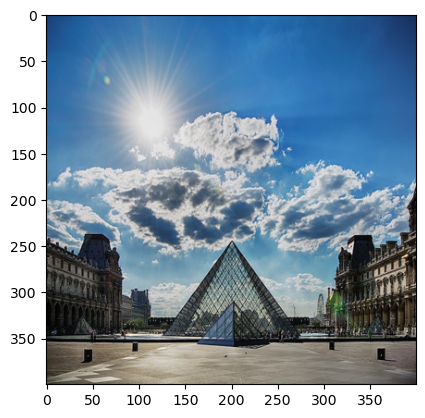

In [3]:
content_image = load_resize('louvre.jpg', 400)

<h5> 1.2) Load style image </h5>

(1, 400, 400, 3)


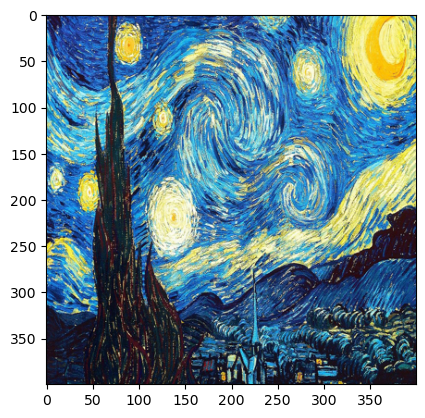

In [4]:
style_image = load_resize('van_gogh.jpg', 400)

<h5> 1.3) Preprocess images </h5>

In [5]:
# Convert the values in content_image and style_image to float32 types, then save as tf.Variable
# Note that tf.image.convert_image_dtype automatically normalises values to range 0-1

preprocessed_content = tf.Variable (tf.image.convert_image_dtype(content_image, tf.float32))        # (1, img_size, img_size, 3)
preprocessed_style = tf.Variable (tf.image.convert_image_dtype(style_image, tf.float32))            # (1, img_size, img_size, 3)

<h3> 2) Load VGG19 model </h3>

In [6]:
# load VGG19 model
# include_top = False --> don't load the three fully connected layers at the top of the model
# choose model trained on imagenet
vgg_model = VGG19(include_top = False, weights='imagenet')

# Freeze weights
vgg_model.trainable = False

# Show all layers of model
for layer in vgg_model.layers:
    print(layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


- To compute the content cost function (J_content), we will use the final layer of block5 ('block5_conv4')
- To compute the style cost function (J_style), we will use: ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [18]:
# Check dimensions of model input and output
print(vgg_model.input.shape) 
print(vgg_model.get_layer('block1_conv1').output.shape)

(None, None, None, 3)
(None, None, None, 64)


In [9]:
# Define VGG19 layers with which to encode the content and style
content_layer = 'block5_conv4'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

# content_model: model that returns the activations of VGG19's hidden layer 'block5_conv4'
# style_models: list of models, each of which outputs the activations of a VGG19 hidden layer

content_model = Model(inputs = vgg_model.input, outputs = vgg_model.get_layer(content_layer).output)
style_models = [Model(inputs = vgg_model.input, outputs = vgg_model.get_layer(style_layer).output) for style_layer in style_layers]

<h3> 3) Cost functions </h3>

<h5> 3.1) Write function to compute content cost </h5>

In [10]:
def content_cost (content, generated):
    """
    Compute a_C -- hidden layer activations representing the content of the content image.
    Compute a_G -- hidden layer activations representing the content of the generated image.
    Compute the content cost by comparing a_G with a_C. 

    Arguments:
    content -- (1, n_H, n_W, n_C)
    generated -- (1, n_H, n_W, n_C)
    
    Returns:
    content_Cost -- scalar
    """
    
    a_C = content_model(content)[0]                     # a_C -- (n_H, n_W, n_C)
    a_G = content_model (generated)[0]                  # a_G -- (n_H, n_W, n_C)

    # Retrieve dimensions
    n_H, n_W, n_C = a_C.shape                    
    
    # Compute the content cost -- based on the square of L2 norm of (a_C - a_G)
    content_cost = (1/(4*n_H*n_W*n_C))* tf.reduce_sum(tf.square(tf.subtract(a_C, a_G)))
    return content_cost

<h5> 3.2) Write function to compute style Cost </h5>

In [11]:
def gram_matrix (A):

    """
    Computes the Gram matrix of A.
    In our case, A will be the "unrolled" filter matrix with the dimensions (n_C, n_H * n_W).

    Arguments:
    A -- matrix of shape (n_C, n_H * n_W)
    
    Returns:
    gram -- Gram matrix of A with shape (n_C, n_C)
    """
    gram = tf.linalg.matmul(A, tf.transpose(A))
    return gram

def style_cost(style_image, generated_image, style_weights = [0.2, 0.2, 0.2, 0.2, 0.2]):

    """
    Compute a_S -- hidden layer activations representing the style of the style image.
    Compute a_G -- hidden layer activations representing the style of the generated image.
    Compute the style cost by comparing a_S with a_G.

    Arguments:
    style_image -- preprocessed_image, 4D tensor (1, n_H, n_W, n_C), with values from 0 to 1
    generated_image -- ditto
    style_weights -- list of weights for the five VGG19 hidden layers 

    Returns:
    J_style_total -- total style cost, scalar
    """

    J_style_total = 0

    # For each of the five VGG hidden layers
    for i, style_model in enumerate(style_models):
        
        # Retrieve hidden layer activations for style image and generated image
        a_S = style_model(style_image)[0]       # a_S = (n_H, n_W, n_C)
        a_G = style_model(generated_image)[0]   # a_G = (n_H, n_W, n_C)

        # Retrieve dimensions
        n_H, n_W, n_C = a_S.shape
        
        # Reshape the images from (n_H * n_W, n_C) to have them of shape (n_C, n_H * n_W)
        a_S = tf.reshape(a_S, shape = [n_H * n_W, n_C])
        a_S = tf.transpose(a_S, perm = [1,0])   # a_S = (n_C, n_H * n_W)

        a_G = tf.reshape(a_G, shape = [n_H * n_W, n_C])
        a_G = tf.transpose(a_G, perm = [1,0])   # a_G = (n_C, n_H * n_W)

        # Compute gram_matrices for both images S and G 
        GS = gram_matrix(a_S)
        GG = gram_matrix(a_G)

        # Compute style cost for current layer
        J_style_layer = (1/(4*n_C*n_C*(n_H*n_W)**2)) * tf.reduce_sum(tf.multiply(tf.subtract(GS, GG), tf.subtract(GS, GG)))

        # Update total

        J_style_total += style_weights[i]*J_style_layer

    return J_style_total

<h3> 4) Necessary post-processing Functions </h3>

In [12]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1
    During optimisation, depending on our gradients and learning rate, 
    the pixels might be updated to values that go beyond the 0-1 range.
    As such, we want a clipper function to keep all pixels within the range of 0 to 1.
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Scales the tensor values (input values are between 0 and 1) back to range of 0 to 255.
    Also convert the values into integers.
    If tensor is 4D, then take only last 3 values.
    Convert this to PIL image.
    
    Arguments:
    tensor -- Tensor
    
    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255                       # Convert values to range 0–255
    tensor = np.array(tensor, dtype=np.uint8)   # Convert into integer type
    if np.ndim(tensor) > 3:                     # If more than 3 dimensions, take only last 3 dimensions.
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

<h3> 5) Optimise </h3>

In [13]:
# Create optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.05)

# Add tf.function() wrapper to execute in graph mode for greater speed.
@tf.function()
def train_step(content, style, generated, alpha, beta):
    """
    - Compute total loss J_total
    - Compute gradient of J_total wrt generated image 
    - Update the generated image based on the gradient
    """
    with tf.GradientTape() as tape:
        J_content = content_cost (content, generated)
        J_style = style_cost(style, generated, style_weights = [0.2, 0.2, 0.2, 0.2, 0.2])
        J_total = alpha * J_content + beta * J_style

    grads = tape.gradient(J_total, generated)
    optimizer.apply_gradients([(grads, generated)])
    generated.assign(clip_0_1(generated))

    return J_total


In [14]:
# initialise the generated image to be the same as the content image
# use tf.identity to create deep copy
# use tf.Variable since "generated" will be updated
content_image = tf.identity(preprocessed_content)         
style_image = tf.identity(preprocessed_style)
generated_image = tf.Variable(tf.identity(preprocessed_content))


# add noise to the generated_image. 
# If the generated_image is only "slightly" similar to the content image, 
# and has a lot of noise, it will more rapidly match the style image.
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(generated_image)


2022-09-27 10:09:09.636900: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch: 0, J_total: 762724.4375


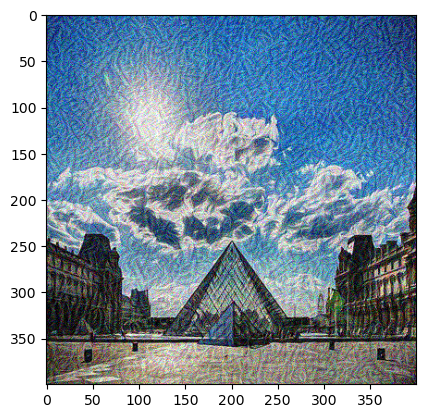

<Figure size 320x320 with 0 Axes>

Epoch: 50, J_total: 2443.005126953125


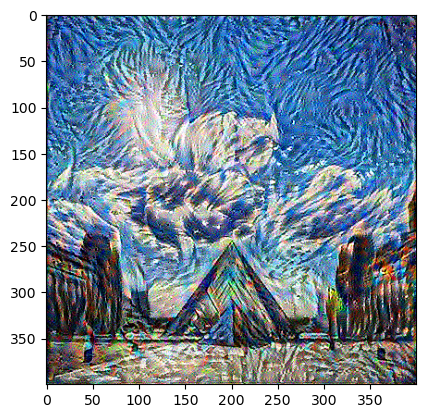

<Figure size 320x320 with 0 Axes>

In [15]:
# Train

epochs = 50
J_lowest = 1000000000
for i in range (epochs + 1):
    J_total = train_step(content_image, style_image, generated_image, alpha = 10, beta = 1000)
    if i % 50 == 0:
        print (f'Epoch: {i}, J_total: {J_total}')
    if i % 50 == 0:
        if J_total < J_lowest:
            J_lowest = J_total
            image = tensor_to_image(generated_image)
            imshow(image)
            plt.figure(figsize = (4,4), dpi = 80)
            plt.show()
            image.save(f'./outputs/image_{i}.jpg')

In [16]:
def plot_gen_image(content_image, style_image, generated_image, epochs, alpha, beta, learning_rate, caption_1, caption_2):
    """
    Plots the original content image, original style image, and final generated image side by side.
    """
    
    fig, ax = plt.subplots(1, 3, figsize = (12, 6), dpi = 100)
    ax[0].imshow(content_image)
    ax[0].set_title('Content image')
    ax[0].set_xlabel(f'\n \n{caption_1}')
    ax[1].imshow(style_image)
    ax[1].set_title('Style image')
    ax[1].set_xlabel(f'\n \n{caption_2}')
    ax[2].imshow(generated_image)
    ax[2].set_title('Generated image')
    ax[2].set_xlabel(f'epochs: {epochs} \n alpha: {alpha} \n beta: {beta} \n learning_rate: {learning_rate}')
    plt.tight_layout()
    #plt.savefig('generated_image.jpg')
    plt.show()

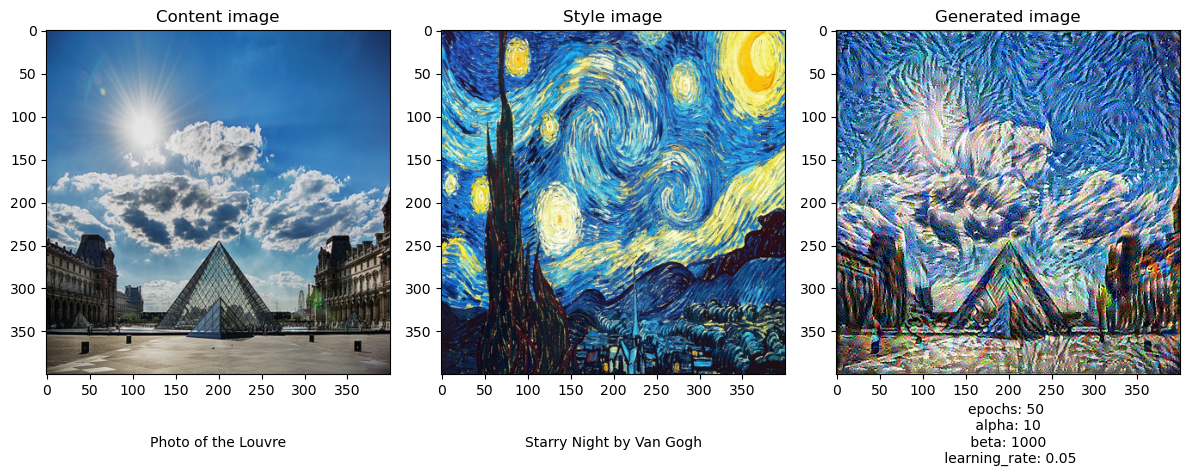

In [17]:
plot_gen_image(preprocessed_content[0], preprocessed_style[0], image, epochs, 10, 1000, 0.05, 'Photo of the Louvre', 'Starry Night by Van Gogh')